# Transfer learning with TensorFlow Hub


[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.



## 1. Setup

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
    pass
import tensorflow as tf

In [4]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

# 2. Load dataset


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

### (Option A) Load full dataset, and split it in train and test dataset

In [ ]:
# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('../data/spectrograms512_test', class_mode="categorical",batch_size=1000, target_size=(512, 512))

In [ ]:
labels = (image_data.class_indices)
labels

In [ ]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_batch, 
                                                    label_batch, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify = label_batch)

### (Option B) Load train and test dataset, if split is done before augmentig data

In [5]:
# Load Training data

# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_train = image_generator.flow_from_directory('../data/dataset/spectrograms512_train', class_mode="categorical", batch_size=32, target_size=(512, 512), save_to_dir = "../data/dataset/spectrograms512_train_temp")

Found 9600 images belonging to 10 classes.


In [6]:
labels_train = (image_data_train.class_indices)
labels_train

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [7]:
#Load test data

# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_test = image_generator.flow_from_directory('../data/dataset/spectrograms512_test', class_mode="categorical", batch_size=32, target_size=(512, 512), save_to_dir = "../data/dataset/spectrograms512_train_temp")

Found 600 images belonging to 10 classes.


In [8]:
labels_test = (image_data_test.class_indices)
labels_test

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

# 3. Download the headless model

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [9]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

Create the feature extractor.

In [10]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [11]:
feature_extractor_layer.trainable = True

In [12]:
input = layers.InputLayer(input_shape=(512, 512, 3), name = "input_layer")


# 4. Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [13]:
model = tf.keras.Sequential([input,
  layers.Conv2D(filters = 3, kernel_size = 65, strides = 2, name = "extra_input_convolution"),
  feature_extractor_layer,
  layers.Dense(image_data_train.num_classes, activation='softmax', name = "class_layer")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
extra_input_convolution (Con (None, 224, 224, 3)       38028     
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
class_layer (Dense)          (None, 10)                12810     
Total params: 2,308,822
Trainable params: 2,274,710
Non-trainable params: 34,112
_________________________________________________________________


# 5. Train the model

Use compile to configure the training process:

In [14]:
model.compile(
  #optimizer=tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True),
  #optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To visualize the training progress, use a custom callback to log the loss and accuracy of each epoch.

In [15]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    self.batch_acc_test = []
    self.batch_losses_test = []


    
  def on_epoch_end (self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.batch_acc_test.append(logs['val_acc'])
    self.batch_losses_test.append(logs['val_loss'])
    self.model.reset_metrics()

### If using option A during data loading use this function

In [64]:

batch_stats_callback = CollectBatchStats()

history = model.fit(X_train, y_train, epochs=20,
                              batch_size = 16,
                              shuffle=True,
                              callbacks = [batch_stats_callback],
                              validation_data=(X_test, y_test))

NameError: name 'X_train' is not defined

### If using option B during data loading use this function

In [16]:

# train model
# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data_train,
                   steps_per_epoch = 25,
                   validation_data = image_data_test,
                   validation_steps = 18,
                   callbacks = [batch_stats_callback],
                   max_queue_size = 10,
                   epochs = 100,
                   ) 

Epoch 1/100
25/25 [==============================] - 2376s 95s/step - loss: 2.0342 - acc: 0.3475 - val_loss: 2.5101 - val_acc: 0.2049
Epoch 2/100
25/25 [==============================] - 2655s 106s/step - loss: 1.6179 - acc: 0.4850 - val_loss: 2.8380 - val_acc: 0.1076
Epoch 3/100
25/25 [==============================] - 2701s 108s/step - loss: 1.3348 - acc: 0.5713 - val_loss: 2.8119 - val_acc: 0.1684
Epoch 4/100
25/25 [==============================] - 2658s 106s/step - loss: 1.2199 - acc: 0.6187 - val_loss: 2.4536 - val_acc: 0.2031
Epoch 5/100
25/25 [==============================] - 2627s 105s/step - loss: 1.1426 - acc: 0.6425 - val_loss: 2.9071 - val_acc: 0.1597
Epoch 6/100
25/25 [==============================] - 2545s 102s/step - loss: 0.9724 - acc: 0.7025 - val_loss: 2.4756 - val_acc: 0.2135
Epoch 7/100
25/25 [==============================] - 2545s 102s/step - loss: 0.9528 - acc: 0.6938 - val_loss: 1.4069 - val_acc: 0.5434
Epoch 8/100
25/25 [==============================] - 254

KeyboardInterrupt: 

# 6. Plot accuracy and loss

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

In [27]:
for line in range(len(batch_stats_callback.batch_losses)): 
    print(line)
    print("loss", batch_stats_callback.batch_losses[line])
    print("loss test", batch_stats_callback.batch_losses_test[line])
    print("acc", batch_stats_callback.batch_acc[line])
    print("acc test", batch_stats_callback.batch_acc_test[line])

                         

0
loss 2.0341693353652954
loss test 2.5100759002897473
acc 0.3475
acc test 0.2048611
1
loss 1.617895245552063
loss test 2.837987118297153
acc 0.485
acc test 0.10763889
2
loss 1.3348172497749329
loss test 2.8119151857164173
acc 0.57125
acc test 0.16840278
3
loss 1.2198558855056763
loss test 2.453601313961877
acc 0.61875
acc test 0.203125
4
loss 1.1426462459564208
loss test 2.9071376058790417
acc 0.6425
acc test 0.15972222
5
loss 0.9724336290359497
loss test 2.475564307636685
acc 0.7025
acc test 0.21354167
6
loss 0.9527598118782044
loss test 1.4069473809666104
acc 0.69375
acc test 0.5434028
7
loss 0.8093740367889404
loss test 1.2316706081231434
acc 0.78125
acc test 0.5868056
8
loss 0.718797619342804
loss test 1.2366496854358249
acc 0.7925
acc test 0.59375
9
loss 0.7553255093097687
loss test 1.5541641844643488
acc 0.7825
acc test 0.49479166
10
loss 0.6312870371341706
loss test 1.1591003371609583
acc 0.83375
acc test 0.6423611
11
loss 0.5807168972492218
loss test 1.0082286298274994
acc 0.8

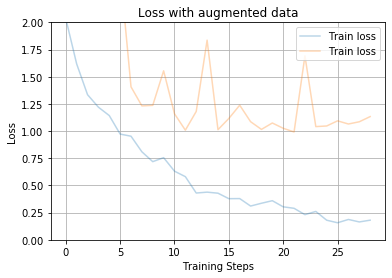

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses, label= 'Train loss', alpha=0.3)
plt.plot(batch_stats_callback.batch_losses_test, label= 'Train loss', alpha=0.3)
plt.legend(loc="upper right")
plt.title("Loss with augmented data")
plt.grid(True)

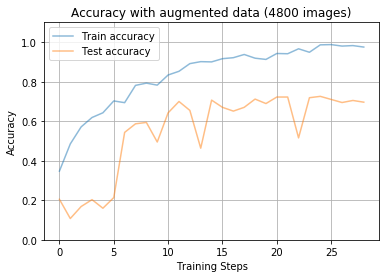

In [18]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(batch_stats_callback.batch_acc, label= 'Train accuracy', alpha=0.5)
plt.plot(batch_stats_callback.batch_acc_test, label= 'Test accuracy', alpha=0.5)
plt.legend(loc="upper left")
plt.title("Accuracy with augmented data (4800 images)")
plt.grid(True)

# 7. Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# 8. Export your model

Now that you've trained the model, export it as a saved model:

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

